In [1]:
import detection_transforms as dt
from data import BedsoreDataset
from utils import draw_bbox
import torch
import random
from torchvision import transforms

In [2]:
# tfmc = Compose([RandomCrop(), ToTensor()])
# tfmc = Compose([])

trans_prob = 0.5
tfmc = dt.Compose([
            dt.RandomCrop(1),
            dt.RandomGaussianBlur((0.1,1),1),
             dt.RandomColorJitter(trans_prob),
            (dt.RandomHorizontalFlip(0.8), dt.RandomVerticalFlip(0.8), dt.RandomRotate(0.8)),
            dt.RandomResize(trans_prob),
            dt.ToTensor(),
            dt.RandomErasing(),
        ])

ds = BedsoreDataset('data', transforms=tfmc)

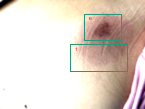

In [17]:
image,target = ds[33]
draw_bbox(image,target)

In [50]:
image,target = ds[1]
W,H = image.size
# _, H,W = image.size()
min_minx = target['boxes'][:,0].min()
min_miny = target['boxes'][:,1].min()
min_maxx = target['boxes'][:,2].max()
min_maxy = target['boxes'][:,3].max()
a = int(random.uniform(0,min_minx))
b = int(random.uniform(0,min_miny))
c = int(random.uniform(min_maxx,W))
d = int(random.uniform(min_maxy,H))
target['boxes'][:,0] -= a
target['boxes'][:,2] -= a
target['boxes'][:,1] -= b
target['boxes'][:,3] -= b

a,b,c,d

TypeError: cannot unpack non-iterable builtin_function_or_method object

In [155]:
image_cropped = image.crop((a,b,c,d))

In [31]:
image_cropped = transforms.ToTensor()(image_cropped)
draw_bbox(image_cropped,target)

NameError: name 'image_cropped' is not defined